In [1]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../../..')))

In [5]:
# to store the KLE surrogate
import json
import time
import numpy as np
import matplotlib.pyplot as plt

# custom modules
import Surrogates.KarhunenLoeveExpansion as KLE

from Models.Chaboche_Model.ChabocheModel import ChabocheModel
from Models.Chaboche_Model.ChabocheModel import chaboche_samples
from Models.Chaboche_Model.ChabocheModel import chaboche_uniform_isoprob_monotonic_transform
from Models.Chaboche_Model.ChabocheModel import generate_model_evaluations

# Model Evaluations

$\sigma(t; \, E, \sigma_{y|0}, Q_{iso}, b_{iso}, n_{iso}, D_{iso}, Q_{kin}, b_{kin} ;  \, \dot{\varepsilon}, \nu)$

## 8 Random Variables

($\nu$ if fixed to 0.3)

1. Young's Modulus: $E$

2. Initial Yield Limit: $\sigma_{y|0}$

### Isotropic Parameters

3. Isotropic Asympotote: $Q_{iso}$

4. Isotropic growth rate: $b_{iso}$

5. Isotrpic exponent: $n_{iso}$

6. Isotropic threshold: $D_{iso}$

### Kinematic Parameters

7. Kinematic Asympotote: $Q_{kin}$

8. Kinematic growth rate: $b_{kin}$



In [7]:
number_of_realizations = 10

t_min = 0
t_max = 2
delta_t = 1e-3 # time step
n_t = int((t_max-t_min)/delta_t)

t_linspace = np.linspace(t_min, t_max, n_t+1)

max_strain = 5e-2
time_to_max_strain = 1

model = ChabocheModel('1D', 'monotonic', max_strain, time_to_max_strain)

0.9267311096191406


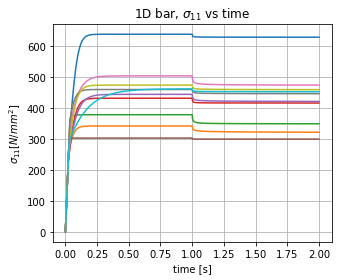

In [8]:
# store samples of parameters
# each row contains 1 set of parameters
SampleSpace = chaboche_samples(number_of_realizations) # [number_of_realizations, 8] matrix

# For monotonic loading
# set b_kin and Q_kin to 0
SampleSpace[:, 6] = 0 # set Q_kin to 0
SampleSpace[:, 7] = 0 # set b_kin to 0

func_evaluations = generate_model_evaluations(model, t_min, t_max, delta_t, 'implicit', SampleSpace, parallel_computation = True)

# plot solution corresponding to each set of random variable
model.stress_plot(t_min, t_max, delta_t, func_evaluations)

Variance quantified by 12 terms = 0.9999988459293458


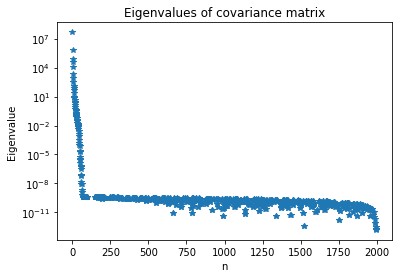

Number of PCE terms: 924
Number of evaluations needed (empirical estimate): 4620
Number of function evaluations: 5000


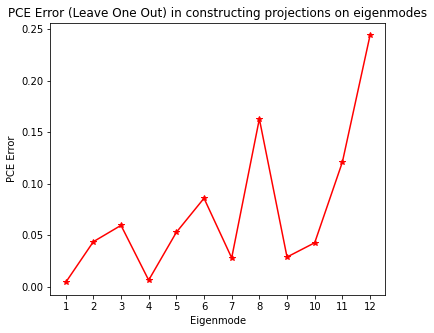

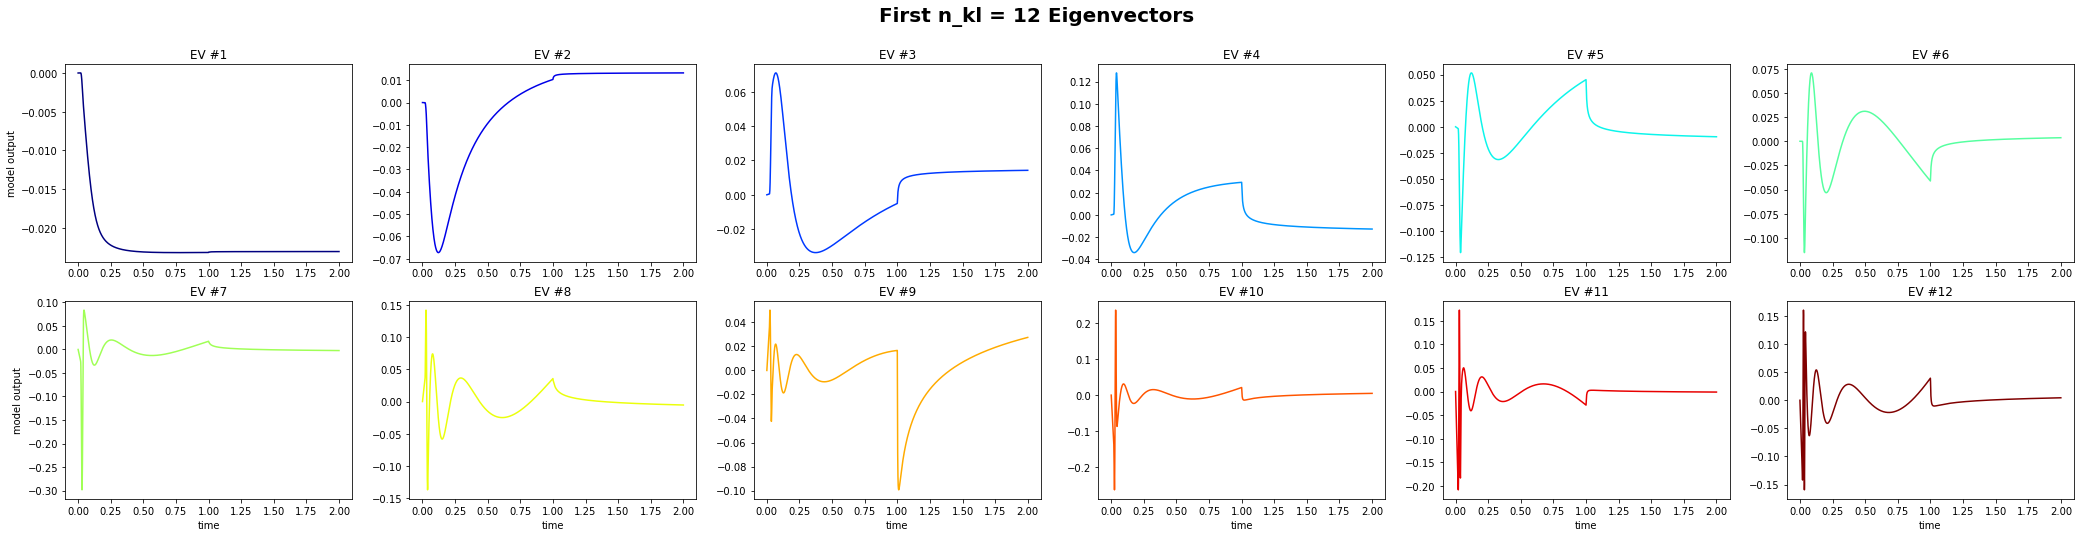

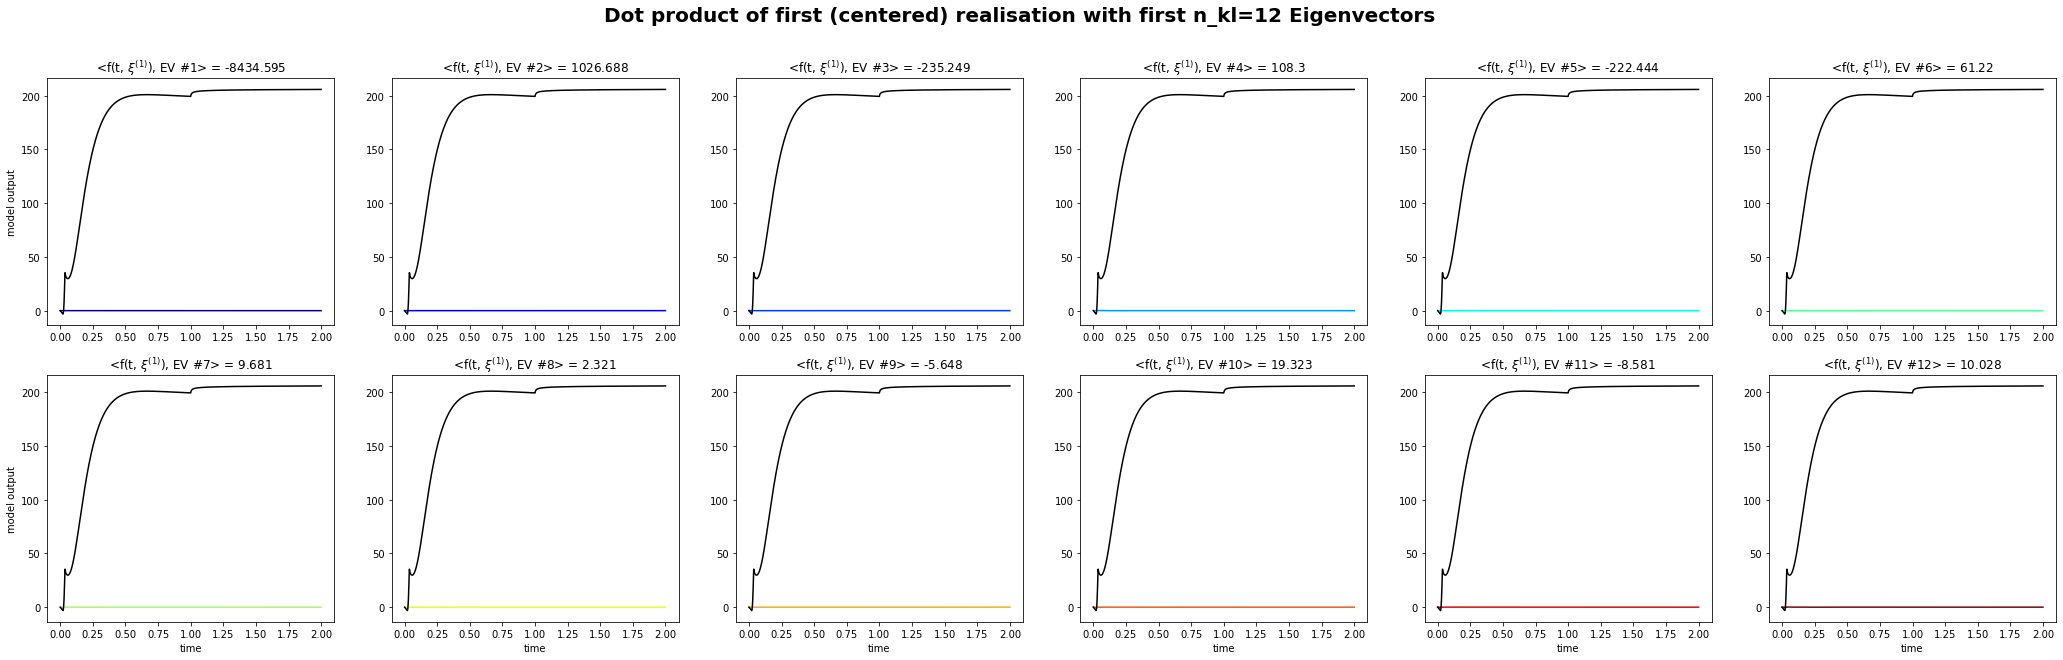

In [5]:
total_polynomial_degree = 6

number_of_random_variables = 6
polynomial_classes_of_random_variables = ['Legendre']*number_of_random_variables

# truncation level for KLE
n_kl = 12

test = KLE.KLE( SampleSpace[:, :6], func_evaluations.T, t_linspace, total_polynomial_degree, n_kl, 
                polynomial_classes_of_random_variables, chaboche_uniform_isoprob_monotonic_transform, PCE_error_flag = True)

test.plot_eigenvectors() # only even n_kl
test.plot_projections() # only even n_kl

/home/i1000609/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


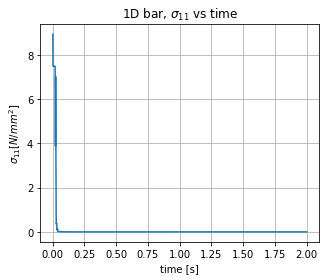

In [6]:
trunc_eig_vec_sq = test.eig_vectors[:,n_kl:]**2 

for i in range(100-n_kl):
    lambda_i = test.eig_values[n_kl+i]
    trunc_eig_vec_sq[:, i] = trunc_eig_vec_sq[:, i] *  lambda_i

error = np.sum(trunc_eig_vec_sq, axis=1)

model.stress_plot(t_min, t_max, delta_t, error *100/np.var(func_evaluations, axis=1))

In [7]:
error_PCE = np.linalg.norm(test.PCE_errors)**2 
error_KLE = 1 - np.sum(test.eig_values[:n_kl])/np.sum(test.eig_values)

error_total = np.sqrt(error_PCE**2 + error_KLE**2) * 100

print(f"Total surrogate error: {error_total:.4f}%" )

Total surrogate error: 11.9635%


# Write to JSON

In [8]:
SURROGATE_INFO = {
                'total_polynomial_order': total_polynomial_degree,
                'n_kl': n_kl,
                'polynomial_classes_of_random_variables':['Legendre']*number_of_random_variables,
                'store_beta':test.store_beta.tolist(),
                'trunc_eig_vectors': test.trunc_eig_vectors.tolist(),
                'Y_mean': test.Y_mean.tolist()    
                }

with open('chaboche_monotonic_strainrate_1.json', 'w') as f:
        json.dump(SURROGATE_INFO, f)

# Read JSON

In [9]:
with open('chaboche_monotonic_strainrate_1.json', 'r') as f:
    trained_model_data = json.load(f)

# Initialise surrogate

In [10]:
KLE_chaboche_monotonic_surrogate = KLE.KLE_surrogate_evaluate(trained_model_data, chaboche_uniform_isoprob_monotonic_transform)

# Test surrogate

In [11]:
SampleSpace_test = chaboche_samples(2_000)

# For monotonic loading
# set b_kin and Q_kin to 0
SampleSpace_test[:, 6] = 0 # set Q_kin to 0
SampleSpace_test[:, 7] = 0 # set b_kin to 0

# True model evaluations
Y_test = generate_model_evaluations(model, t_min, t_max, delta_t, 'implicit', SampleSpace_test, parallel_computation = True)

# Surrogate model evaluations
Y_surrogate = KLE_chaboche_monotonic_surrogate.surrogate_evaluate(SampleSpace_test[:, :6])

# Relative error 
print(f"Relative L2 Error: {np.linalg.norm(Y_surrogate - Y_test.T)*100/np.linalg.norm(Y_test.T):.2f}%")

Relative L2 Error: 1.89%


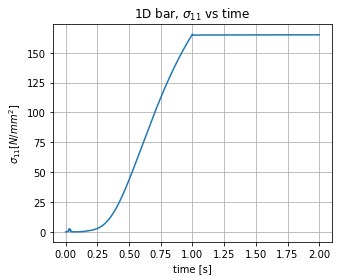

In [12]:
# Point-wise mean square error
pointwise_error = np.mean(np.square(Y_surrogate - Y_test.T), axis=0)

# Plot
model.stress_plot(t_min, t_max, delta_t, pointwise_error.T)

/home/i1000609/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


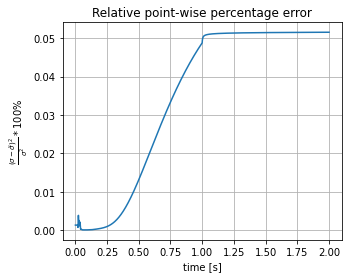

In [13]:
# Point-wise mean square error percentage
# ! Initial value is zero hence divide by 0 error appears
pointwise_error = np.mean(np.square(Y_surrogate - Y_test.T), axis=0) * 100 / np.mean(np.square(Y_test.T), axis=0)

# Plot
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(t_linspace, pointwise_error)
ax.set_title('Relative point-wise percentage error')
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\frac{(\sigma - \tilde{\sigma})^2}{\sigma^2} * 100 \%$')
ax.grid()

plt.show()

/home/i1000609/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


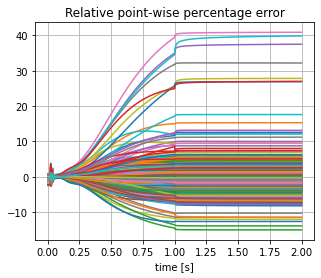

In [14]:
# Point-wise mean square error percentage
# ! Initial value is zero hence divide by 0 error appear
pointwise_error = (Y_surrogate - Y_test.T) * 100 / Y_test.T

# Plot
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(t_linspace, pointwise_error.T)
ax.set_title('Relative point-wise percentage error')
ax.set_xlabel('time [s]')
ax.grid()

plt.show()

# How well are the eigenvalues approximated?

$X_{t}=\sum_{i=1}^{\infty} x_{i} e_{i}(t), \quad \text { in } L^{2}(\Omega)$

where coefficients $x_{i}$ are given by $x_{i}(\omega)=\int_{D} X_{t}(\omega) e_{i}(t) d t$ and satisfy the following.

1. $\mathrm{E}\left[x_{i}\right]=0$
2. $\mathrm{E}\left[x_{i} x_{j}\right]=\delta_{i j} \lambda_{j}$.
3. $\operatorname{Var}\left[x_{i}\right]=\lambda_{i}$.

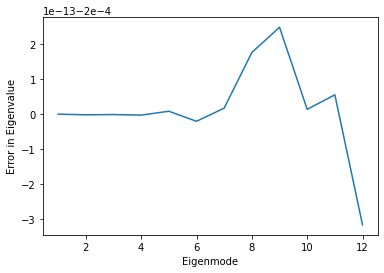

In [15]:
# Checking Property 3 
diff_eig_val = np.zeros((n_kl, 1))

for i in range(n_kl):
    diff_eig_val[i] = (np.var(test.Y_i[:, i]) - test.eig_values[i]) / test.eig_values[i]

plt.plot(np.linspace(1, n_kl, n_kl), diff_eig_val)
plt.xlabel('Eigenmode')
plt.ylabel('Error in Eigenvalue')

plt.show()

In [16]:
calibration_test = np.array([[2e5, 250, 50, 100, 2, 100, 0, 0]])

# True model evaluations
Y_test_calibration = generate_model_evaluations(model, t_min, t_max, delta_t, 'implicit', calibration_test, parallel_computation = False)

# Surrogate model evaluations
Y_surrogate_calibration = KLE_chaboche_monotonic_surrogate.surrogate_evaluate(calibration_test[:, :6])

# Y_surrogate_calibration = (Y_test_calibration.T - Y_surrogate_calibration) * 100 / Y_surrogate_calibration

# Y_surrogate_calibration[0, 9]

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


In [17]:
Y_test_calibration[10]

array([100.])

In [18]:
Y_surrogate_calibration[0, 10]

100.35397410338147

In [19]:
calibration_test = np.array([[205257.926022, 294.841480, 262.896301, 474.207398, 3.628963, 47.946532, 0, 0]])

my_default_vls = KLE_chaboche_monotonic_surrogate.surrogate_evaluate(calibration_test[:, :6])

# Surrogate Variance

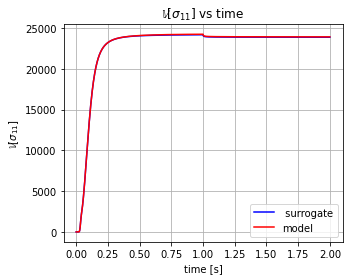

In [20]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(t_linspace, np.var(Y_surrogate, axis=0), color = 'blue', label = ' surrogate')
ax.plot(t_linspace, np.var(Y_test.T, axis=0),  color = 'red', label = 'model')

ax.set_title(r'$\mathbb{V}[\sigma_{11}]$ vs time')
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\mathbb{V}[\sigma_{11}]$')
ax.grid()
ax.legend()

plt.show()

# Variance error

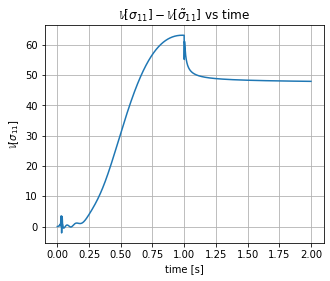

In [21]:
fig, ax = plt.subplots(figsize=(5,4))

error_var = (np.var(Y_test.T, axis=0) - np.var(Y_surrogate, axis=0))

# variance of model evals - variance of surrogate evals
ax.plot(t_linspace, error_var)

ax.set_title(r'$\mathbb{V}[\sigma_{11}] - \mathbb{V}[\tilde{\sigma}_{11}]$ vs time')
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\mathbb{V}[\sigma_{11}]$')
ax.grid()

# Relative Variance error

/home/i1000609/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


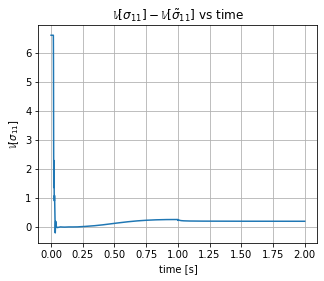

In [22]:
fig, ax = plt.subplots(figsize=(5,4))

# ! Initial value is zero hence divide by 0 error appear
rel_error_var = (np.var(Y_test.T, axis=0) - np.var(Y_surrogate, axis=0)) * 100 / np.var(Y_test.T, axis=0)

# variance of model evals - variance of surrogate evals
ax.plot(t_linspace, rel_error_var)

ax.set_title(r'$\mathbb{V}[\sigma_{11}] - \mathbb{V}[\tilde{\sigma}_{11}]$ vs time')
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\mathbb{V}[\sigma_{11}]$')
ax.grid()

In [23]:
model_variance = np.var(Y_test.T, axis=0)

In [24]:
surrogate_variance = np.var(Y_surrogate, axis=0)

In [25]:
surrogate_variance_rel_error = (np.var(Y_test.T, axis=0) - np.var(Y_surrogate, axis=0)) * 100 / np.var(Y_test.T, axis=0)

/home/i1000609/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


# Realizations of model vs. Surrogate

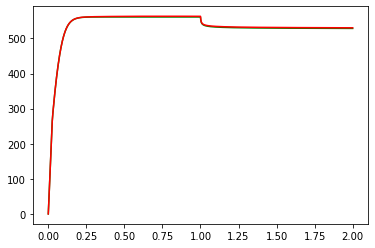

In [26]:
which_realisation = 2 # out of 499

plt.plot(t_linspace, Y_test.T[which_realisation, :], color = 'green')
plt.plot(t_linspace, Y_surrogate[which_realisation, :], color = 'red')

plt.show()

# Eigenprojections Histogram

test.Y_i [N, n_kl] are the projections on the eigenbasis.


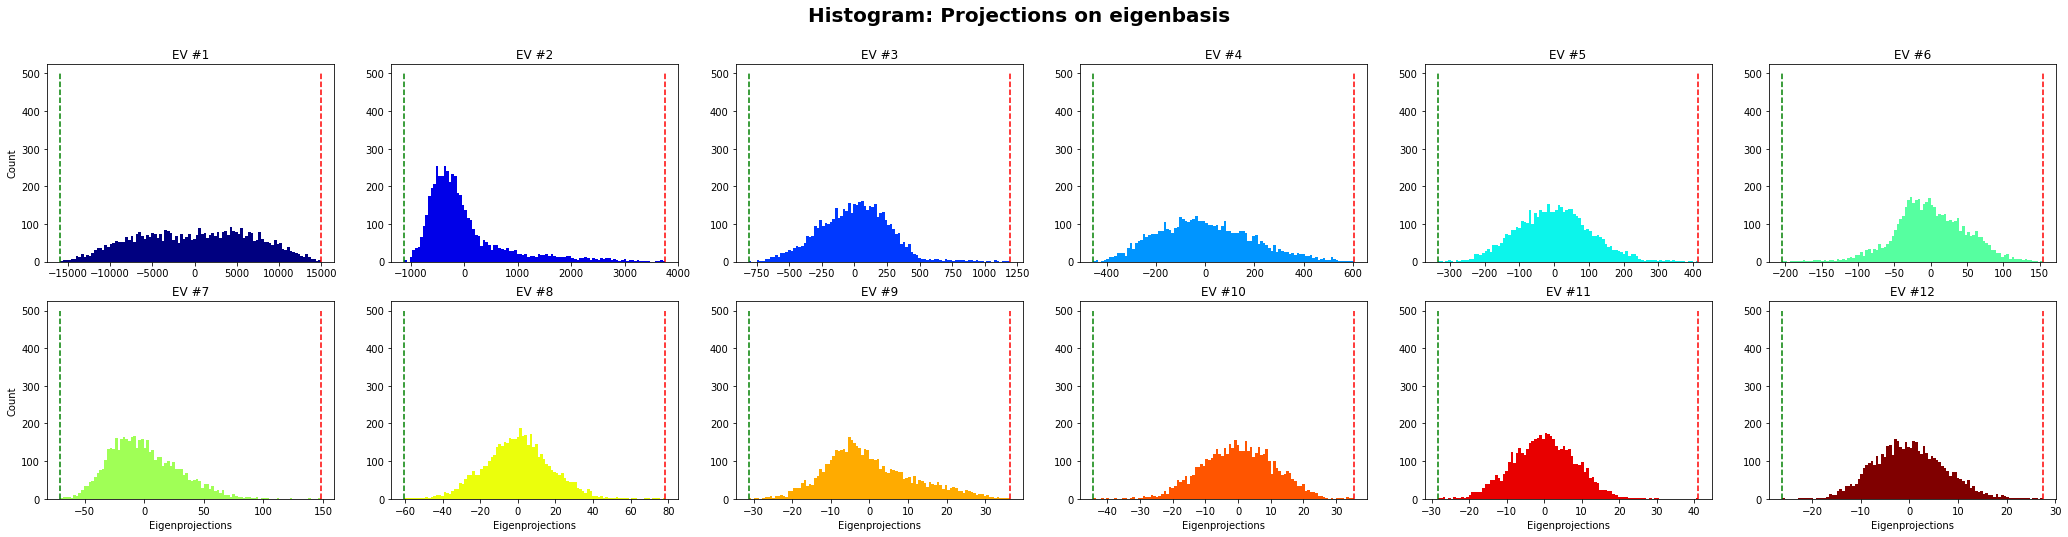

In [27]:
n_bins = 100

# fig, ax = plt.subplots(2, int(n_kl/2), figsize=(3*n_kl, 8), sharex=True, sharey=True)
fig, ax = plt.subplots(2, int(n_kl/2), figsize=(3*n_kl, 8))

# change colors in for loop
colors = iter(plt.cm.jet(np.linspace(0,1,n_kl)))

for i in np.arange(n_kl):

    row = int(i//(n_kl/2))
    column = int(i%(n_kl/2))

    # choose one column corresponding to projections on ith eigenbasis
    ax[row][column].hist(test.Y_i[:, i], bins=n_bins, color=next(colors))
    ax[row][column].vlines(np.min(test.Y_i[:, i]), ymin = 0, ymax = 500, color = 'green', linestyle = '--')
    ax[row][column].vlines(np.max(test.Y_i[:, i]), ymin = 0, ymax = 500, color = 'red', linestyle = '--')

    'Formatting'
    if column == 0:
        ax[row][column].set_ylabel('Count')
    if row == 1:
        ax[row][column].set_xlabel('Eigenprojections')
    
    ax[row][column].set_title('EV #' + str(i+1))

fig.suptitle("Histogram: Projections on eigenbasis", fontsize=20, fontweight= "bold")

plt.show()

# Smoothness of marginals

In [ ]:
SampleSpace_marginals = chaboche_samples(1000)

# Fix all but one
SampleSpace_marginals[:, 0] = 2e5
# SampleSpace_marginals[:, 1] = 250
SampleSpace_marginals[:, 2] = 50
SampleSpace_marginals[:, 3] = 100
SampleSpace_marginals[:, 4] = 2
SampleSpace_marginals[:, 5] = 100
SampleSpace_marginals[:, 6] = 0 # set Q_kin to 0
SampleSpace_marginals[:, 7] = 0 # set b_kin to 0

model_marginals = generate_model_evaluations(model, t_min, t_max, delta_t, 'implicit', SampleSpace_marginals, parallel_computation = True) # model
# Y_hat = KLE_chaboche_monotonic_surrogate.surrogate_evaluate(SampleSpace_marginals[:, :6]) # surrogate

In [ ]:
# center the process
model_marginals_c = model_marginals - Y_hat.mean(axis=0)

In [ ]:
# Project on basis
Y_i_marginals = model_marginals_c.T @ KLE_chaboche_monotonic_surrogate.trunc_eig_vectors

In [ ]:
which_eigenbasis = 0

plt.hist(Y_i_marginals[:, which_eigenbasis], bins= 50)

plt.show()

In [ ]:
n_bins = 100

# fig, ax = plt.subplots(2, int(n_kl/2), figsize=(3*n_kl, 8), sharex=True, sharey=True)
fig, ax = plt.subplots(2, int(n_kl/2), figsize=(3*n_kl, 8))

# change colors in for loop
colors = iter(plt.cm.jet(np.linspace(0,1,n_kl)))

for i in np.arange(n_kl):

    row = int(i//(n_kl/2))
    column = int(i%(n_kl/2))

    # choose one column corresponding to projections on ith eigenbasis
    ax[row][column].hist(Y_i_marginals[:, i], bins=n_bins, color=next(colors))
    ax[row][column].vlines(np.min(Y_i_marginals[:, i]), ymin = 0, ymax = 500, color = 'green', linestyle = '--')
    ax[row][column].vlines(np.max(Y_i_marginals[:, i]), ymin = 0, ymax = 500, color = 'red', linestyle = '--')

    'Formatting'
    if column == 0:
        ax[row][column].set_ylabel('Count')
    if row == 1:
        ax[row][column].set_xlabel('Eigenprojections')
    
    ax[row][column].set_title('EV #' + str(i+1))

fig.suptitle("Histogram: Projections on eigenbasis", fontsize=20, fontweight= "bold")

plt.show()